<a href="https://colab.research.google.com/github/lstarke/churn_prediction/blob/main/LeandroStarke_Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

## Sobre Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Entendendo o problema

Este projeto tem como objetivo criar um modelo de Machine Learning capaz de detectar se um determinado cliente de uma empresa de telecom cancelará ou não sua assinatura com a empresa. Para realizar esta detecção serão usadas dados do dataset que traçam um perfil do cliente.

## Etapas do projeto

1. Aquisição dos dados
1. Entendimento das colunas do dataset
    1. Conhecer as variáveis independentes
    1. Identificar variável alvo (dependendte)
1. Identificar valores nulos e correções de tipagem
    1. Definir estratégia de preenchimento dos valores nulos com:
        * Zero
        * Média
        * Mediana
        * Frequência
1. Identificar inconsistências nos valores do dataset e adequar tipos das variáveis
   
1. Avaliar/aplicar técnicas de feature engineering
1. Estudar a correlação entre os dados
1. Ver o balanceamento das classes
1. Verificar tipos de distribuição
    1. Gausiana
    1. Uniforme
    1. Logarítmica
    1. etc
1. Identificar variávei numéricas e categóricas
1. Identificar qual melhor estratégia de normalização para as variáveis numéricas (Normalização ou Standarização?)
1. Identificar qual melhor estratégia de normalização para as variáveis categóricas (OneHotEncoder, LabelEncoder ou Dummies)
    1. Classificar variáveis categóricas, Contínuas, Discretas ou Ordinais
1. Identificar algoritmos mais apropriados para o problema
1. Construir modelo
    1. Analisar as variáveis mais significativas para cada algoritmo
    1. Definir técnicas de avaliação do modelo
        1. Simple Hold-Out validation
        1. K-Fold validation
    1. *Hyperparameters Tuning* (se necessário)
    1.  Verificar o desempenho do(s) modelo(s) e considerar métodos *Ensemble*
        1. Identificar melhores métricas para avaliar o modelo construido

# Instalação de pacotes

In [1]:
# descomentar linhas abaixo quando rodar a primeira vez
# !pip install matplotlib==3.6.3
# !pip install -U pandas-profiling

# Importação dos pacotes

In [2]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
# from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# configurações
pd.set_option('display.max_columns', None)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

%matplotlib inline

<ipython-input-2-a076a86f6510>:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


# Data Understanding

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [3]:
# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Dicionário das variáveis

In [4]:
# listando as colunas do dataset
list(df.columns)

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

1. `customerID:` Código do cliente
1. `gender:` Sexo do cliente
1. `SeniorCitizen:` O cliente é idoso?
1. `Partner:` O cliente possui parceiro?
1. `Dependents:` O cliente possui dependentes?
1. `tenure:` Quantidade de tempo que o cliente está na assinatura (em meses)
1. `PhoneService:` Possui telefone?
1. `MultipleLines:` Possui multlipas linhas de telefone?
1. `InternetService:`Qual o tipo de internet que o cliente possui?
1. `OnlineSecurity:` Utiliza algum tipo de software/serviço de segurança para navegar na internet?
1. `OnlineBackup:` Utiliza algum tipo de serviço para fazer backup de seus dados?
1. `DeviceProtection:` Possui algum tipo de proteção/garantia de seu dispositivo?
1. `TechSupport:` Possui direito a suporte técnico?
1. `StreamingTV:`Possui alguma assinatura de TV por streaming?
1. `StreamingMovies:` Possui alguma assinatura de Filmes por streaming?
1. `Contract:` Qual a durabilidade do plano ?
1. `PaperlessBilling:` Fatura sem papel?
1. `PaymentMethod:` Método de pagamento utilizado
1. `MonthlyCharges:` Custo mensal do cliente
1. `TotalCharges:` Custo total do cliente
1. `Churn:` O cliente abandonou a empresa e/ou cancelou a assinatura? (**Variável dependente/alvo**)

Com este detalhamento das variáveis conseguimos identificar que o valor ao qual queremos fazer previsões está na coluna `Churn`. Sendo assim, está coluna será a nossa variável alvo ou, nossa variável dependente.

## Tipos das variáveis

In [5]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Várias colunas do nosso DataFrame são do tipo texto (object). Se voltarmos e olharmos as cinco primeiras linhas do nosso DataFrame percebemos que possivelmente estas colunas são variáveis categóricas.

Além disso, a variável `TotalCharges` é do tipo object, o que não parece estar correto, visto que esta variável contem o custo total do cliente. Temos um problema de tipagem nesta variável!

## Análise Exploratória dos Dados (EDA)

Para acelerar o processo de analise exploratória farei uso do pacote [Pandas Profiling](https://pandas-profiling.ydata.ai/docs/master/index.html) para acelerar esta analise.

In [6]:
profile = ProfileReport(df, title="DataFrame EDA")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Analisando o relatório gerado pelo Pandas Profiling podemos destacar alguns pontos:**

1. O DataFrame não possui dados faltantes em suas colunas (Aparentemente);
1. Temos 83.8% de pessoas jovens e apenas 16.2% de pessoas idosas;
1. 70% das pessoas não possui dependentes;
1. Em ``tenure`` visualizando o histograma é possivel identificar três grupos de pessoas, as que tem um tempo de trabalho entre 0-12, de 12-70 e maiores que 70;
1. A maioria dos contratos (``Contract``) são mensais;
1. A grande parte das pessoas paga uma mensalidade de até 30;
1. A variável ``TotalCharges`` é categórica e precisará ser adequada para o tipo float;
1. Nossa variável alvo ``Churn`` está desbalanceada;
1. A mensalidade (``MonthlyCharges``) tem uma alta correlação com o serviços oferecidos, o que faz total sentido;


In [7]:
# armazenando os nome das colunas originais vindas do dataset antes da etapa de feature engineering
original_col_names = df.columns

### Variáveis com valores NaN

In [8]:
# comprehension list para encontrar features com valores NaN
features_with_na = [features for features in df.columns if df[features].isna().sum() > 0]

# imprimindo a lista das features encontradas
if not features_with_na:
  print("Nenhuma feature com valores NaN")
else:
  for feature in features_with_na:
    print(f"{feature} = {np.round(df[feature].isna().mean(), 4)}%")

Nenhuma feature com valores NaN


### Variáveis numéricas

In [9]:
# método auxiliar que retorna features numéricas
def get_numerical_features(df: pd.DataFrame) -> list:
  # comprehension list para identificar as variáveis numéricas do DataFrame
  return [feature for feature in df.columns if df[feature].dtypes != "O"]

In [10]:
numerical_features = get_numerical_features(df)

# imprimindo a quantidade de variáveis numéricas encontradas
print(f"Qtde de variáveis numéricas: {len(numerical_features)}")

# imprimindo as 5 primeiras linhas do DataFrame somente das variáveis numéricas
df[numerical_features].head()

Qtde de variáveis numéricas: 3


,SeniorCitizen,tenure,MonthlyCharges
0,0,1,29.85
1,0,34,56.95
2,0,2,53.85
3,0,45,42.30
4,0,2,70.70


### Variáveis discretas

In [11]:
# comprehension list para identificar variáveis discretas dentre as variáveis numéricas encontradas
discrete_features = [feature for feature in numerical_features if len(df[feature].unique()) < 25]

# imprimindo a quantidade de variáveis discretas
print(f"Qtde de variáveis discretas: {len(discrete_features)}")

# imprimindo as 5 primeiras linhas do DataFrame
df[discrete_features].head()

Qtde de variáveis discretas: 1


,SeniorCitizen
0,0
1,0
2,0
3,0
4,0


In [12]:
# verificando valores únicos em SeniorCitizen
df.SeniorCitizen.unique()

array([0, 1])

Nesta analise podemos ver que dentre as variáveis numéricas encontramos ```SeniorCitizem``` que se enquadra em uma variável categórica, indicando se o indivíduo é idoso ou não e, ```TotalCharges``` não entrou na filtragem de variáveis numéricas por ser do tipo ```Object```.

Para melhorar a tipagem do DataFrame, vamos converter ```SeniorCitizen``` para o tipo boolean.

In [13]:
# convertendo o tipo da variável SeniorCitizen de int64 para bool
df.SeniorCitizen = df.SeniorCitizen.astype(bool)

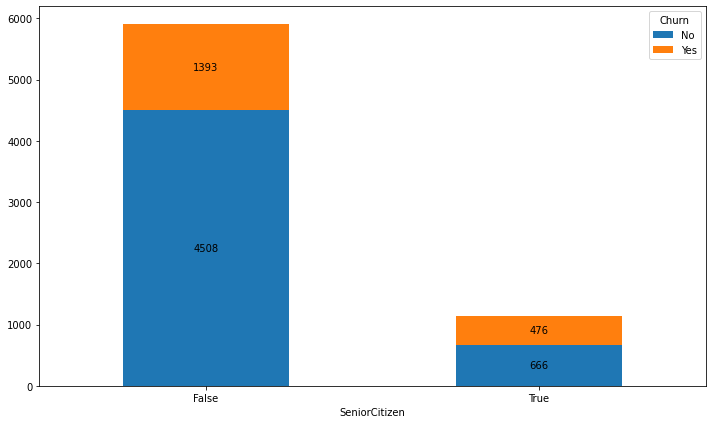

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

# utilizando crosstab para encontrar uma relação entre SeniorCitizen e Churn
ct_churn_seniorcitizen = pd.crosstab(df.SeniorCitizen, df.Churn)

# criando gráfico de barras empilhadas
ax = ct_churn_seniorcitizen.plot(ax=ax, kind="bar", stacked=True, rot=0);

# adicionando as anotações de cada barra
for c in ax.containers:
  ax.bar_label(c, label_type="center")

fig.tight_layout()

### Variáveis contínuas

In [15]:
continuous_features = [feature for feature in numerical_features if feature not in discrete_features]
print(f"Qtde de variáveis contínuas = {len(continuous_features)}")
print(f"Variáveis contínuas: {continuous_features}")

Qtde de variáveis contínuas = 2
Variáveis contínuas: ['tenure', 'MonthlyCharges']


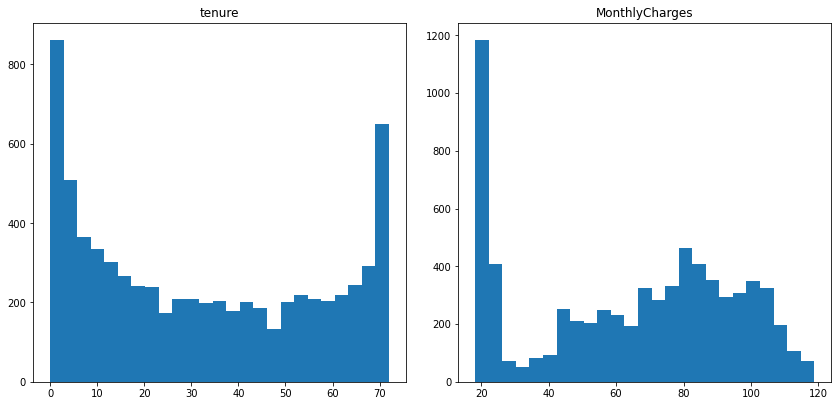

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=len(continuous_features), figsize=(12,6))

for ax, feature in zip(axs.flat, continuous_features):  
  df[feature].hist(ax=ax, bins=25, grid=False)
  ax.set_title(feature);

fig.tight_layout(pad=2.0)

O método ``.hist()`` possui um parâmetro ``bins`` onde é possivel criarmos agrupamentos utilizando ranges da variável ``tenure``. Com ``bins=25`` é possivel ver uma distribuição nos dados.



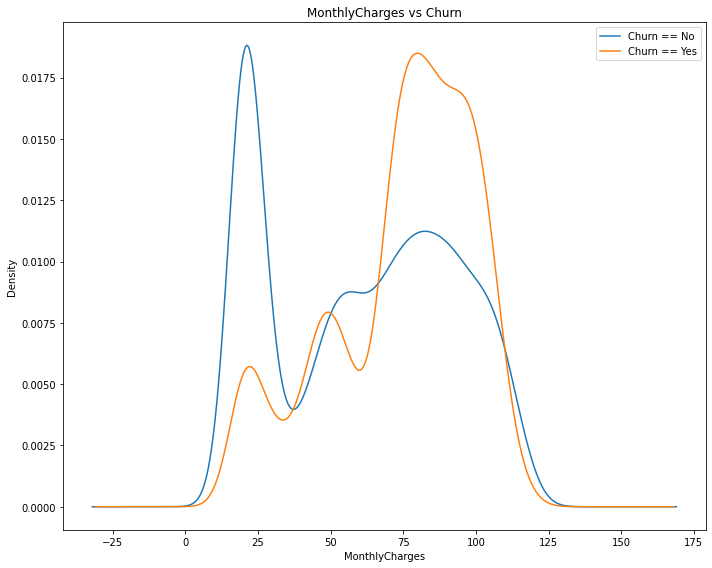

In [17]:
fig, ax = plt.subplots(figsize=(10,8))

df[df.Churn == 'No'].MonthlyCharges.plot.density(ax=ax, label="Churn == No")
df[df.Churn == 'Yes'].MonthlyCharges.plot.density(ax=ax, label="Churn == Yes")

ax.set_xlabel("MonthlyCharges")
ax.set_title("MonthlyCharges vs Churn")
ax.legend()

plt.tight_layout()

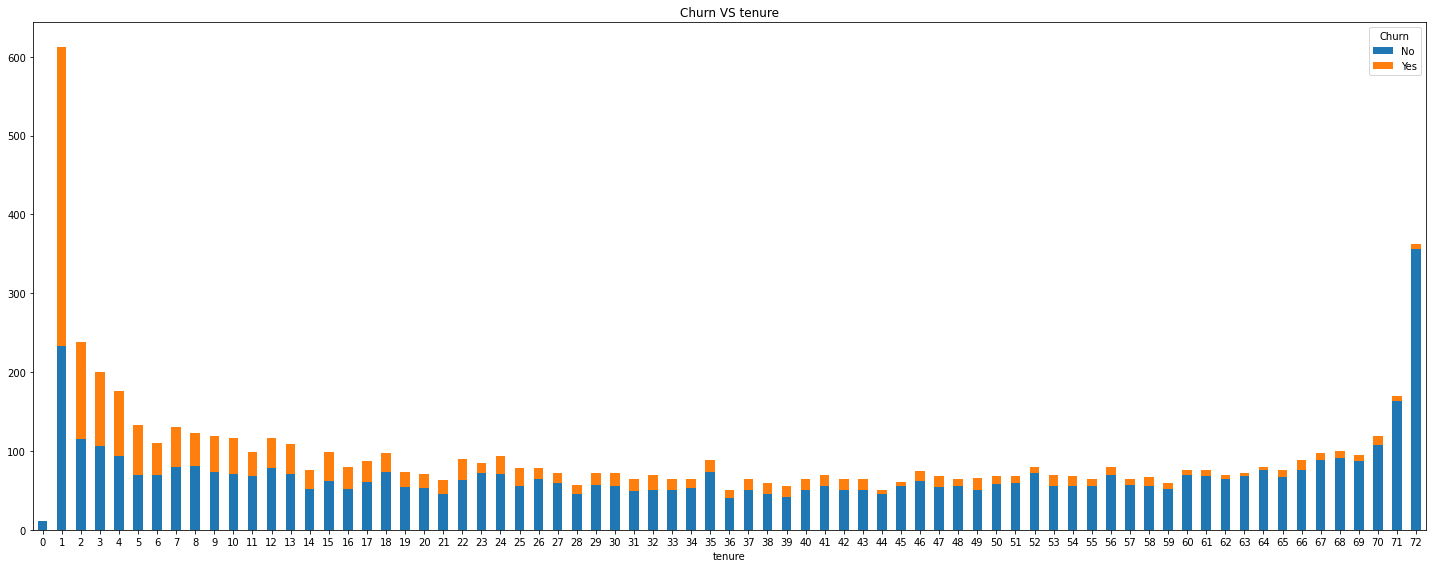

In [18]:
fig, ax = plt.subplots(figsize=(20,8))

# utilizando crosstab para encontrar uma relação entre SeniorCitizen e Churn
ct_churn_tenure = pd.crosstab(df.tenure, df.Churn)

# criando gráfico de barras empilhadas
ax = ct_churn_tenure.plot(ax=ax, kind="bar", stacked=True, rot=0);

ax.set_title("Churn VS tenure");

# adicionando as anotações de cada barra
# for c in ax.containers:
#   ax.bar_label(c, label_type="center")

fig.tight_layout()

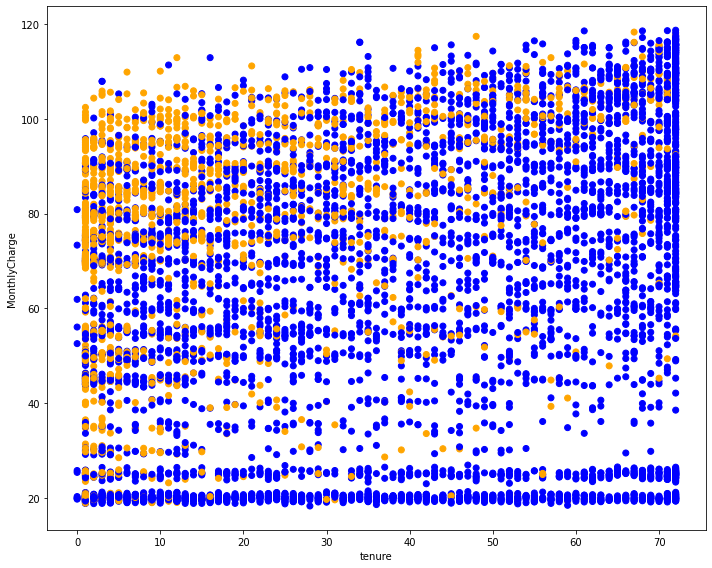

In [19]:
fig, ax = plt.subplots(figsize=(10,8))

col = np.where(df["Churn"] == "Yes", 'orange', 'blue')

ax.scatter(df["tenure"], df["MonthlyCharges"], c=col)
ax.set_xlabel("tenure")
ax.set_ylabel("MonthlyCharge")

plt.tight_layout()

Clientes com mais tempo de casa tendem a abandonar menos a empresa e/ou cancelar a assinatura.

### Variáveis categóricas

In [20]:
# método auxiliar que retorna features categóricas
def get_categorical_features(df: pd.DataFrame) -> list:
  return [feature for feature in df.columns if df[feature].dtypes == "O"]

In [21]:
# filtrando as variáveis categórical do DataFrame
categorical_features = get_categorical_features(df)
categorical_features

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges',
 'Churn']

In [22]:
df[categorical_features].head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,1889.5,No
2,3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,108.15,Yes
3,7795-CFOCW,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),1840.75,No
4,9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,151.65,Yes


In [23]:
for feature in categorical_features:
  print(f"{feature}: {len(df[feature].unique())} unique values")

customerID: 7043 unique values
gender: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
TotalCharges: 6531 unique values
Churn: 2 unique values


In [24]:
print(f"Qtde features categóricas: {len(categorical_features)}")

Qtde features categóricas: 18


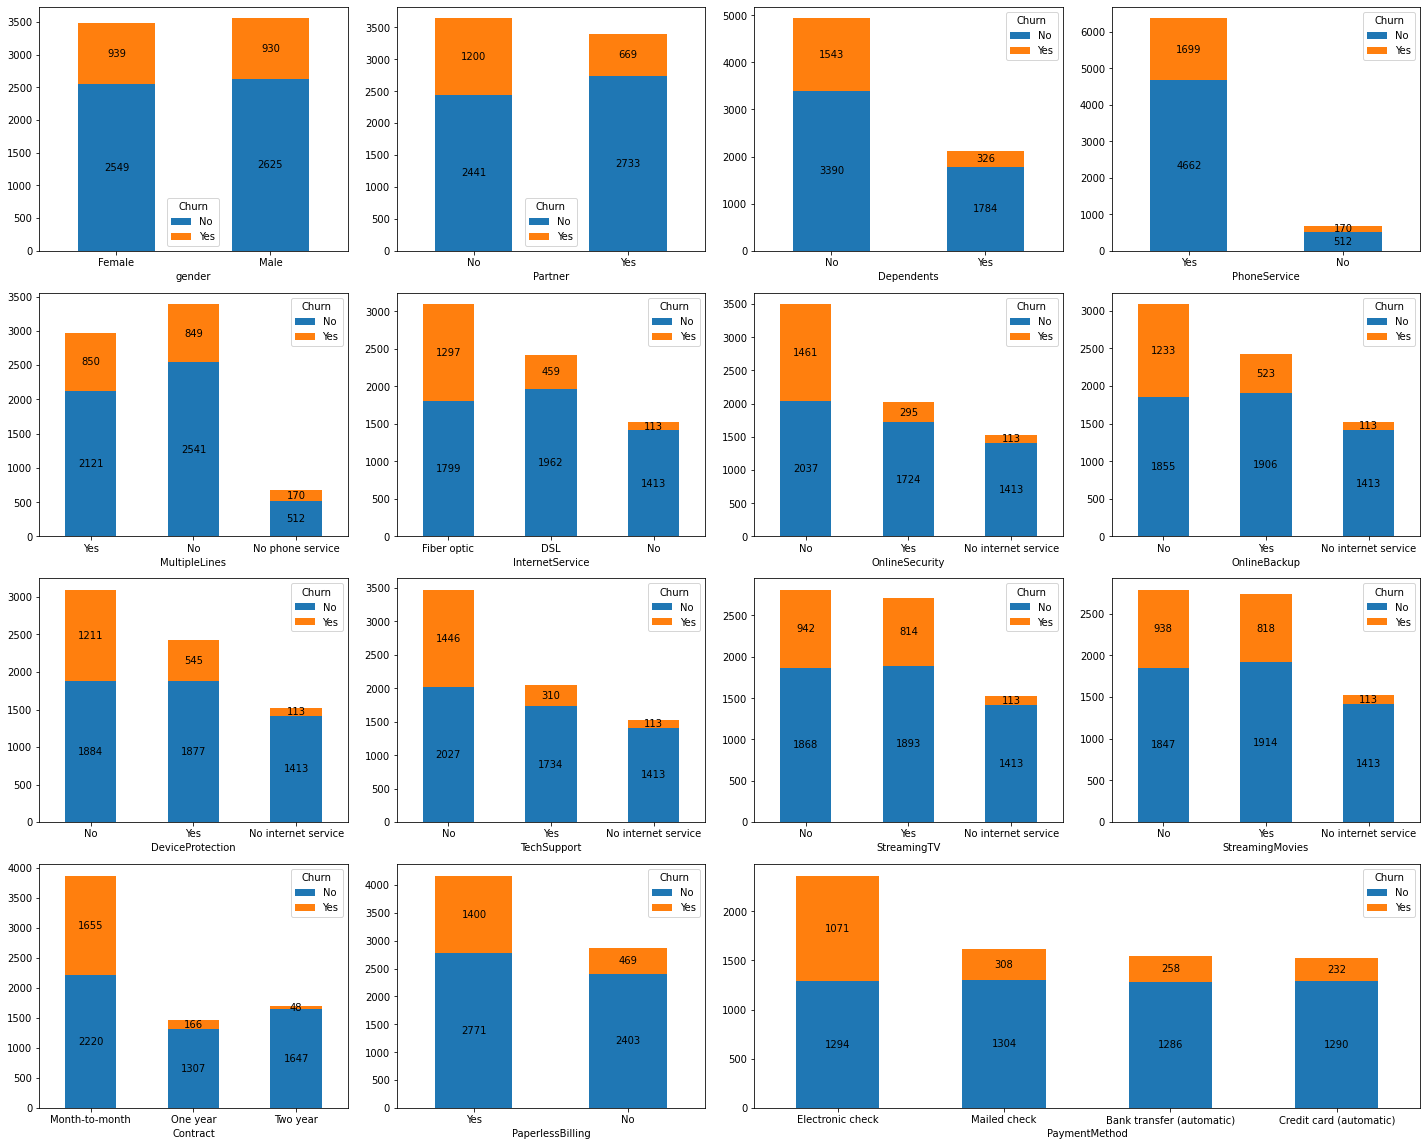

In [25]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20,16))

for ax, feature in zip(axs.flat, categorical_features[1:-2]):

  # mesclando colunas somente para feature "PaymentMethod"
  if feature == "PaymentMethod":
    gs = axs[2, 2].get_gridspec() # pegando a especificação do grid

    # removendo a celula 4,2
    for ax in axs[-1, 2:]:
      ax.remove()

    # adicionando novo subplot mesclando célula da linha 4 (-1) e colunas 2 até a última coluna (2:)
    ax = fig.add_subplot(gs[-1, 2:])

  # utilizando crosstab para encontrar uma relação entre SeniorCitizen e Churn
  # ordenando por Churn==Yes
  ct = pd.crosstab(df[feature], df.Churn).sort_values(["Yes"], ascending=False)

  # criando gráfico de barras empilhadas
  ct.plot(ax=ax, kind="bar", stacked=True, rot=0);
  
  # adicionando as anotações de cada barra
  for c in ax.containers:
    ax.bar_label(c, label_type="center")

fig.tight_layout(pad=1.0)

Pontos relevantes sobre o gráfico acima:

* Para clientes que não tem companheiro ou dependentes há uma maior taxa de abandono;
* Clientes com fibra optica tem uma maior taxa de abandono;
* Cliente que não assinam algum tipo de serviço como ```ONlineSecurity```, ```OnlineBackup```, ```DeviceProtection``` e ```TechSupport``` tem uma maior taxa de abandono;
* Contratos mensais tem uma maior taxa de abandono;
* Pagamentos sem papel e método de pagamento manual (eletronic check) possuem uma mais taxa de abandono.



# Data Preparation

## Corrigindo tipagem de ```TotalCharges```

Conforme identificado nas etapas acima, a variável ```TotalCharges``` é do tipo Object e precisa ser tipada como float.

In [26]:
# convertendo coluna TotalCharges para o tipo float64
try:
  df.TotalCharges = df.TotalCharges.astype("float")
  df.dtypes()
except ValueError as error:
  print(f"ValueError: {error}")

ValueError: could not convert string to float: ''


A tentativa de conversão acima retornou um erro impossibilitando a conversão do valor " " (string vazia) em um dado numérico do tipo float. Isto quer dizer que na coluna ``TotalCharges`` temos um dado que é nulo (vazio).

In [27]:
# contando quantos registros com espaço em branco em TotalCharges
df[df.TotalCharges == ' '].TotalCharges.value_counts()

     11
Name: TotalCharges, dtype: int64

In [28]:
# listando os registros com espaço vazio em TotalCharges
df[df.TotalCharges == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,False,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,False,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,False,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,False,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,False,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,False,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,False,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,False,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,False,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,False,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


Como pode ser visto, temos 11 linhas no DataFrame onde ``TotalCharges`` é uma string vazia.

In [29]:
# convertento string vazia para tipo NaN
df.TotalCharges.replace(" ", np.nan, inplace=True)

# validando a conversão verificando a quantidade de NaN's
df.TotalCharges.isna().sum()

11

In [30]:
# convertendo coluna TotalCharges para o tipo float64
df.TotalCharges = df.TotalCharges.astype("float")

# verificando o tipo de dado de TotalCharges
df.TotalCharges.dtypes

dtype('float64')

Com esta manobra conseguimos converter a coluna ``TotalCharges`` para float mesmo tendo NaN's.

Mesmo que esta coluna possua dados vazios (NaN), isto facilitará nossa vida nas próximas etapas para corrigir este problema. Existem algumas técnicas que podemos aplicar para eliminar estes NaN's e corrigir este problema.

In [31]:
# rodando novamente o comando para identificar variáveis numéricas
numerical_features = [feature for feature in df.columns if df[feature].dtypes != "O"]

# verificando estatísticas descritivas das variáveis numéricas
df[numerical_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


In [32]:
# preenchendo NaNs com a mediana da coluna TotalCharges
df.TotalCharges.fillna(df.TotalCharges.median(), inplace=True)

# verificando novamente a quantidade de NaNs 
df.TotalCharges.isna().sum()

0

## Preenchendo valores faltantes em ```TotalCharges```

Neste momento vamos iniciar preenchendo os NaNs da variável ``TotalCharges`` com a mediana. Isso por que analisando alguns dados estatísticos dessa variável pelo método ``.describe()``, pode-se ver uma diferença considerável entre a média e mediana, além disso, geralmente a média é afetada por valores outliers.

Com as estatísticas descritivas retornadas pelo método ``.describe()`` podemos concluir que:

* ``SeniorCitizen`` mesmo sendo classificada aqui como uma variável numérica ela é categórica;
* ``tenure``, ``MonthlyCharges``e ``TotalCharges`` aparentemente não possuem nenhum outlier.

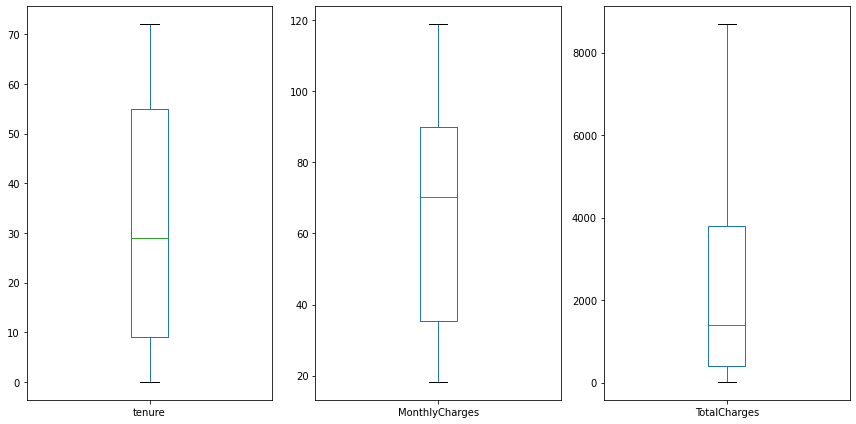

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=len(numerical_features[1:]), figsize=(12, 6))

for index, column in enumerate(numerical_features[1:]):
  df.boxplot(column=column, ax=ax[index], grid=False)

fig.tight_layout()
plt.show()

In [34]:
# rodando novamento o comando para a seleção das variáveis contínuas
continuous_features = [feature for feature in numerical_features if feature not in discrete_features]

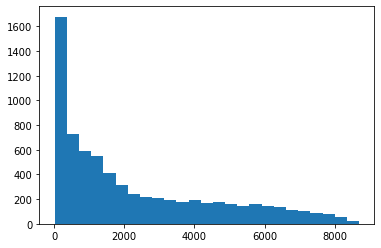

In [35]:
df["TotalCharges"].hist(bins=25, grid=False);

Podemos ver no histograma acima que a mais parte das pessoas tem um gasto total entre 0 e 2000.

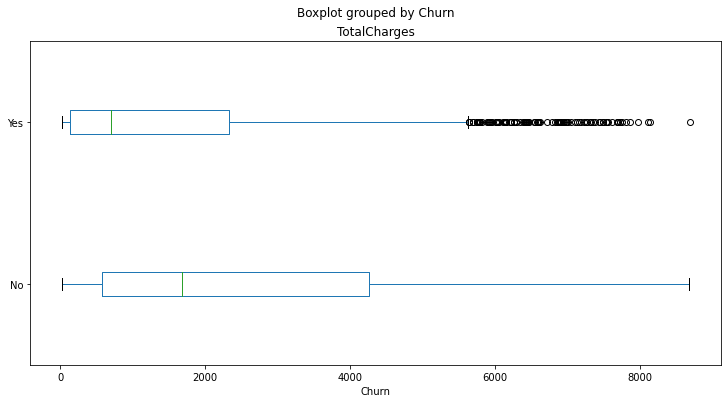

In [36]:
df.boxplot(column="TotalCharges", by="Churn", figsize=(12, 6), grid=False, vert=False);

Alem disso, no boxplot acima é possivel deduzir que o abandono acontece em valores anuais da mensalidade elevados, sendo identificados pelo boxplot como outliers onde o valor de Churn é "Yes".

Isto pode ser um possível motivo de abandono, um valor anual de mensalidade elevado. Neste caso, poderia-se realizar um trabalho promocional para estes clientes com um gasto anual elevado.

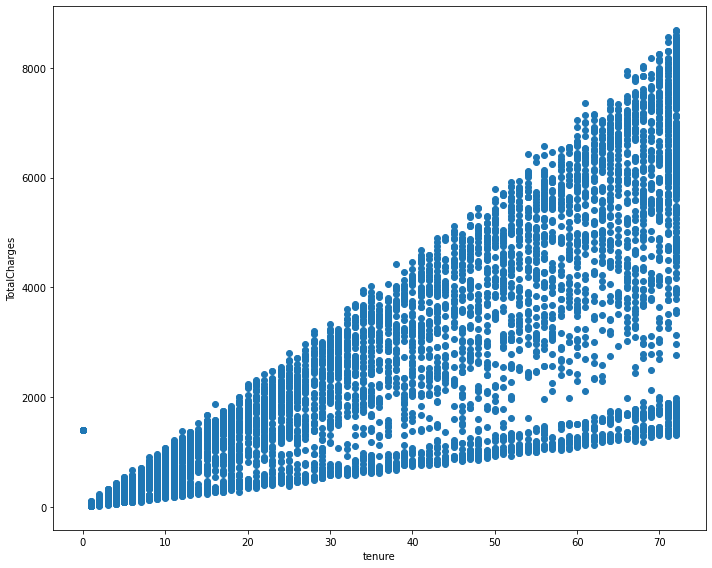

In [37]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(df["tenure"], df["TotalCharges"])
ax.set_xlabel("tenure")
ax.set_ylabel("TotalCharges")

plt.tight_layout()

Quanto mais o tempo de permanencia do cliente maiores seus gastos anuais.

In [38]:
df[["tenure", "TotalCharges"]].corr()

,tenure,TotalCharges
tenure,1.000000,0.825464
TotalCharges,0.825464,1.000000


Correlação de 0.82 entre ```tenure``` e ```TotalCharges```.

Com esta experiência que tivemos com a variável ``TotalCharges`` é possível que existam mais colunas em nosso DataFrame que tenha strings (``''``) vazias e estamos sendo enganados pelo comando ``df.isna().sum()``. 

Vamos inspencionar isso nas próximas etapas.

In [39]:
categorical_features = [feature for feature in df.columns if df[feature].dtypes == "O"]

# laço para detectar strings vazias na colunas categóricas
for column in categorical_features:
  x = np.where(df[column].str.strip() == "")
  print(f"{column}: {len(x[0])}")

customerID: 0
gender: 0
Partner: 0
Dependents: 0
PhoneService: 0
MultipleLines: 0
InternetService: 0
OnlineSecurity: 0
OnlineBackup: 0
DeviceProtection: 0
TechSupport: 0
StreamingTV: 0
StreamingMovies: 0
Contract: 0
PaperlessBilling: 0
PaymentMethod: 0
Churn: 0


Aparentemente não temos mais nenhuma coluna com string vazia no DataFrame.

In [40]:
# atualizando lista de variáveis numéricas
numerical_features = get_numerical_features(df)
numerical_features

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

## Feature engineering

Feature engineering é o processo de extrair, transformar e selecionar as variáveis (também conhecidas como "features" ou características) dos dados brutos que serão utilizados como entrada para um modelo de machine learning.

O objetivo do feature engineering é melhorar a qualidade dos dados de entrada, criando variáveis mais informativas que possam ajudar o modelo a aprender e generalizar melhor a partir dos dados disponíveis. Algumas técnicas comuns de feature engineering incluem:

1. Seleção de variáveis: identificar quais variáveis são mais relevantes para o modelo e descartar aquelas que não agregam informações significativas.
1. Transformação de variáveis: converter variáveis em diferentes escalas, transformar variáveis categóricas em numéricas e criar novas variáveis a partir de combinações de variáveis existentes.
1. Criação de variáveis: gerar novas variáveis que possam ajudar a explicar o comportamento dos dados, como por exemplo, calcular a média, desvio padrão ou outros indicadores a partir de outras variáveis.


O feature engineering é uma das etapas mais importantes no processo de modelagem em machine learning, pois pode influenciar significativamente o desempenho e a precisão dos modelos. Um bom feature engineering pode ajudar a aumentar a eficiência do modelo, melhorar sua capacidade de generalização e reduzir o risco de overfitting.

### tenure

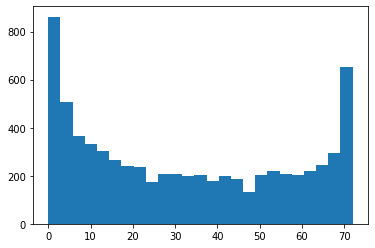

In [41]:
# analisando a distribuição separando a variável em 6 grupos
df.tenure.hist(grid=False, bins=25);

O método ```.hist()```possui um parâmetro ```bins``` onde é possivel criarmos agrupamentos utilizando ranges da variável ```tenure```. Com ```bins=25``` é possivel ver uma distribuição em nosso dados. Vamos rotular estes dados em três categorias.

In [42]:
print(f"Qtde de clientes com apenas um mês: {df[df.tenure==0].shape[0]}")

Qtde de clientes com apenas um mês: 11


In [43]:
# Verificando a variável alvo (Churn) em clientes que estão no primeiro mês
df[df.tenure==0].Churn.value_counts()

No    11
Name: Churn, dtype: int64

Clientes que estão no primeiro mês não contribuirão para o nosso modelo na predição da variável alvo, além disso, todos os clientes que estão no primeiro mês não abondonarão o serviço contratado obviamente. Sendo assim, optei por remove-los do DataFrame.

In [44]:
# removendo clientes que estão no primeiro mês
df.drop(df[df.tenure == 0].index, axis=0, inplace=True)

print(df[df.tenure==0].shape[0])

0


In [45]:
# método para identificar se o cliente está em determinado range da variável tenure
def tenure_description(tenure: int) -> str:
  if tenure >= 0 and tenure <= 12:
    return "up to 1 year"
  elif tenure > 12 and tenure <=60: 
    return "greater than a year to 5 years"
  else:
    return "more than 5 years"

# cria uma nova coluna no DataFrame chamada tenure_description
df = df.assign(tenure_description = df.tenure.apply(tenure_description))

# imprimindo 5 primeiras linhas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_description
0,7590-VHVEG,Female,False,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,up to 1 year
1,5575-GNVDE,Male,False,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,greater than a year to 5 years
2,3668-QPYBK,Male,False,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,up to 1 year
3,7795-CFOCW,Male,False,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,greater than a year to 5 years
4,9237-HQITU,Female,False,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,up to 1 year


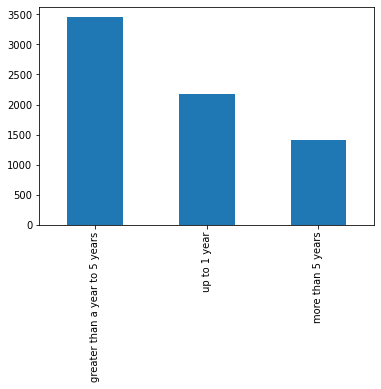

In [46]:
df.tenure_description.value_counts().plot(kind="bar");

Com a nova coluna que criamos ``tenure_description`` podemos ver que grande parte dos clientes em nosso DataFrame possui de 2 a 5 anos no mesmo emprego.

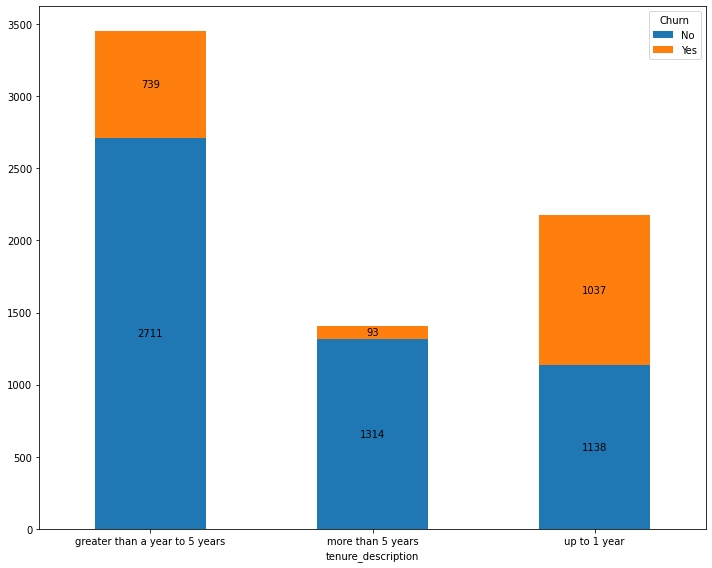

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
  
ct = pd.crosstab(df["tenure_description"], df.Churn)
# criando gráfico de barras empilhadas
ct.plot(ax=ax, kind="bar", stacked=True, rot=0);

# adicionando as anotações de cada barra
for c in ax.containers:
  ax.bar_label(c, label_type="center")

fig.tight_layout()

Pessoas com até 1 ano de assinatura tem uma taxa de abandono próximo de 50%. Outro grupo de pessoas que vale ter atenção são as pessoas assinantes a mais de 5 anos.

### MonthlyCharges

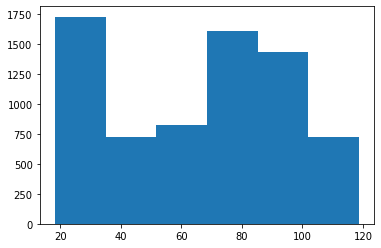

In [48]:
df.MonthlyCharges.hist(bins=6, grid=False);

O histograma acima nos mostra possíveis três grupos em nosso DataFrame de clientes.

Que pagam uma mensalidade de:

1. até 30
2. entre 31 e 70
3. entre 71 até 100
4. maior que 100



In [49]:
def monthly_charges_description(monthly_charge: float) -> str:
  if monthly_charge < 31.0:
    return "up to 30"
  elif monthly_charge > 30.0 and monthly_charge < 70.0:
    return "31 to 70"
  elif monthly_charge > 70 and monthly_charge < 100:
    return "71 to 100"
  else:
    return "more than 100"

df = df.assign(MonthlyCharges_description = df.MonthlyCharges.apply(monthly_charges_description))

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_description,MonthlyCharges_description
0,7590-VHVEG,Female,False,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,up to 1 year,up to 30
1,5575-GNVDE,Male,False,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,greater than a year to 5 years,31 to 70
2,3668-QPYBK,Male,False,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,up to 1 year,31 to 70
3,7795-CFOCW,Male,False,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,greater than a year to 5 years,31 to 70
4,9237-HQITU,Female,False,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,up to 1 year,71 to 100


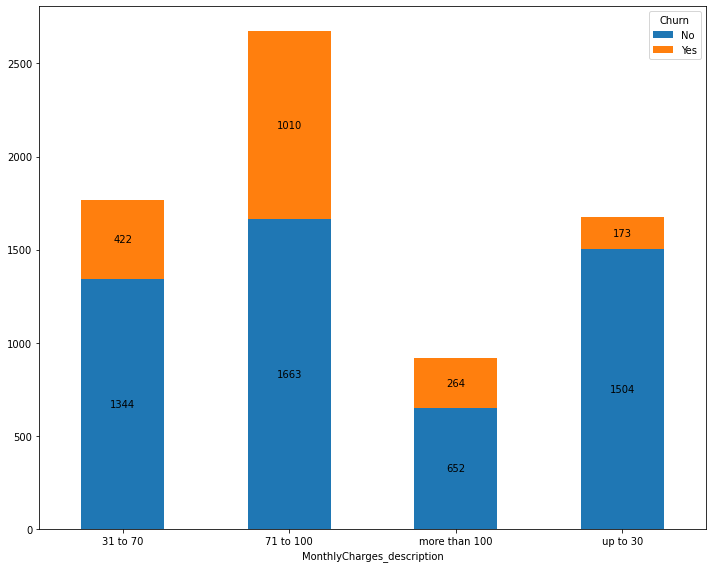

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
  
ct = pd.crosstab(df["MonthlyCharges_description"], df.Churn)
# criando gráfico de barras empilhadas
ct.plot(ax=ax, kind="bar", stacked=True, rot=0);

# adicionando as anotações de cada barra
for c in ax.containers:
  ax.bar_label(c, label_type="center")

fig.tight_layout()

### Partner e Dependents

In [51]:
df = df.assign(partner_dependents = df.apply(lambda x: "{}_{}".format(x.Partner, x.Dependents), axis=1))

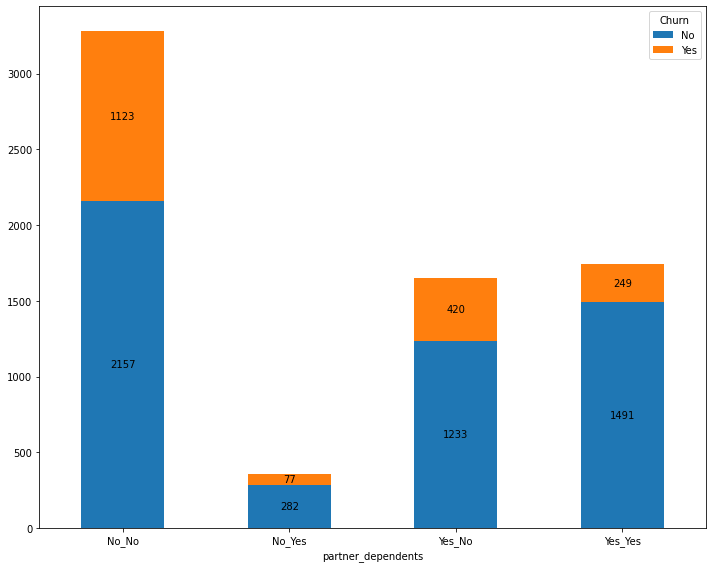

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))
  
ct = pd.crosstab(df["partner_dependents"], df.Churn)
# criando gráfico de barras empilhadas
ct.plot(ax=ax, kind="bar", stacked=True, rot=0);

# adicionando as anotações de cada barra
for c in ax.containers:
  ax.bar_label(c, label_type="center")

fig.tight_layout()

Há uma maior concentração de abandono em clientes que não tem parceiro e não tem dependentes.

In [53]:
# criando uma nova coluna chamada has_partner_dep que terá a informação booleana se o cliente tem algum parceiro e/ou dependente ou nenhum deles
df = df.assign(has_partner_or_dep = df.partner_dependents.apply(lambda x: "no" if "Yes" not in x else "yes"))

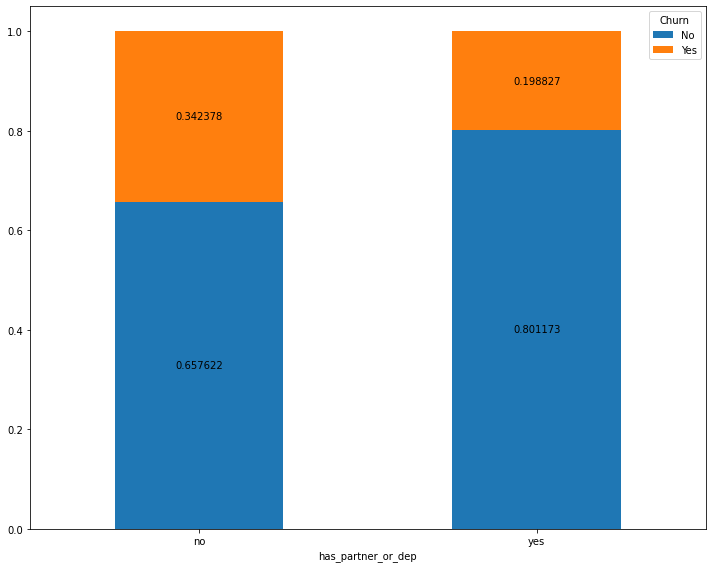

In [54]:
fig, ax = plt.subplots(figsize=(10, 8))
  
ct = pd.crosstab(df["has_partner_or_dep"], df.Churn, normalize="index")
# criando gráfico de barras empilhadas
ct.plot(ax=ax, kind="bar", stacked=True, rot=0);

# adicionando as anotações de cada barra
for c in ax.containers:
  ax.bar_label(c, label_type="center")

fig.tight_layout()

Clientes que não tem parceiro e dependentes possuem uma taxa de abandono 15% maior em relação aos clientes que possuem parceiros e/ou dependentes.

### Agrupando serviços de streaming

In [55]:
df = df.assign(streaming_services = df.apply(lambda x: "{}_{}".format(x.StreamingTV, x.StreamingMovies), axis=1))

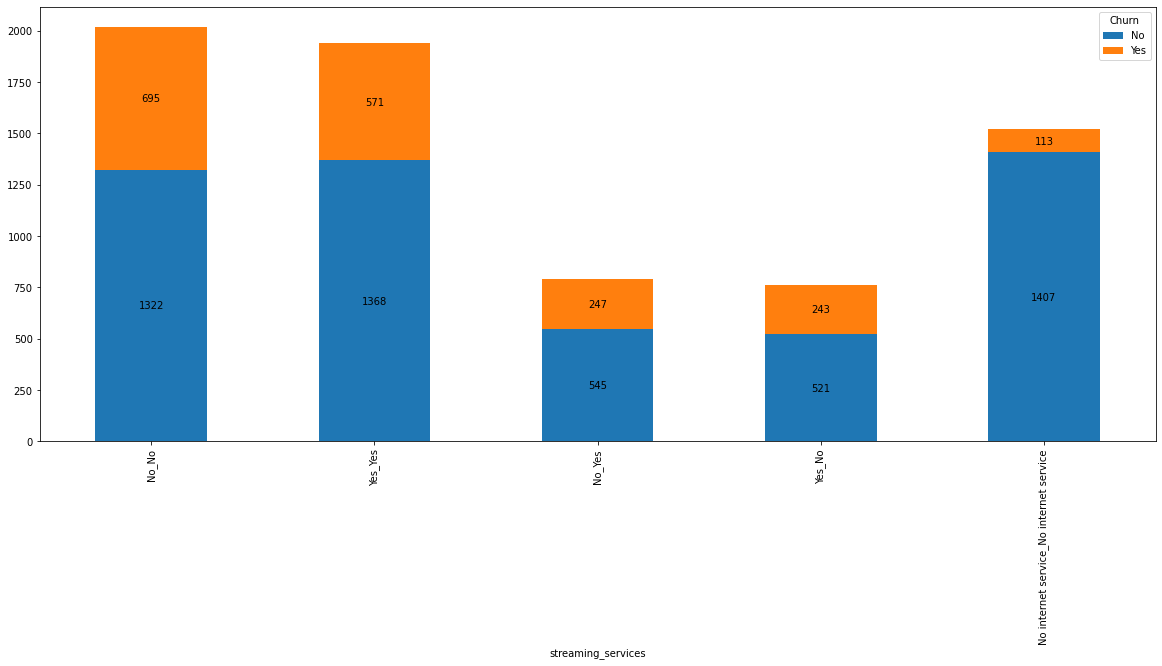

In [56]:
fig, ax = plt.subplots(figsize=(20, 8))
  
ct = pd.crosstab(df["streaming_services"], df.Churn).sort_values(["Yes"], ascending=False)
# criando gráfico de barras empilhadas
ct.plot(ax=ax, kind="bar", stacked=True, rot=90);

# # adicionando as anotações de cada barra
for c in ax.containers:
  ax.bar_label(c, label_type="center")

# fig.tight_layout()

In [57]:
# agrupando clientes que possuem nenhum tipo de streaming e clientes streaming
df = df.assign(streaming_services = df.streaming_services.apply(lambda x: "no" if "Yes" not in x or "No internet service" in x else "yes"))

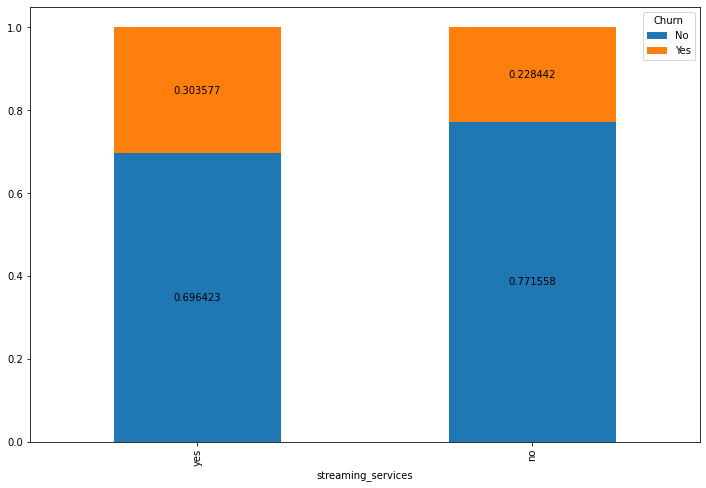

In [58]:
fig, ax = plt.subplots(figsize=(12, 8))
  
ct = pd.crosstab(df["streaming_services"], df.Churn, normalize="index").sort_values(["Yes"], ascending=False)
# criando gráfico de barras empilhadas
ct.plot(ax=ax, kind="bar", stacked=True, rot=90);

# # adicionando as anotações de cada barra
for c in ax.containers:
  ax.bar_label(c, label_type="center")

# fig.tight_layout()

Clientes que possuem assinados algum serviço de streaming tem uma taxa de abandono 8% maior em relação aos clientes que não possuem nenhum serviço de streaming assinado.

### Agrupando serviços de segurança

In [59]:
df = df.assign(security_services = df.apply(lambda x: "{}_{}_{}".format(x.OnlineSecurity, x.OnlineBackup, x.DeviceProtection), axis=1))

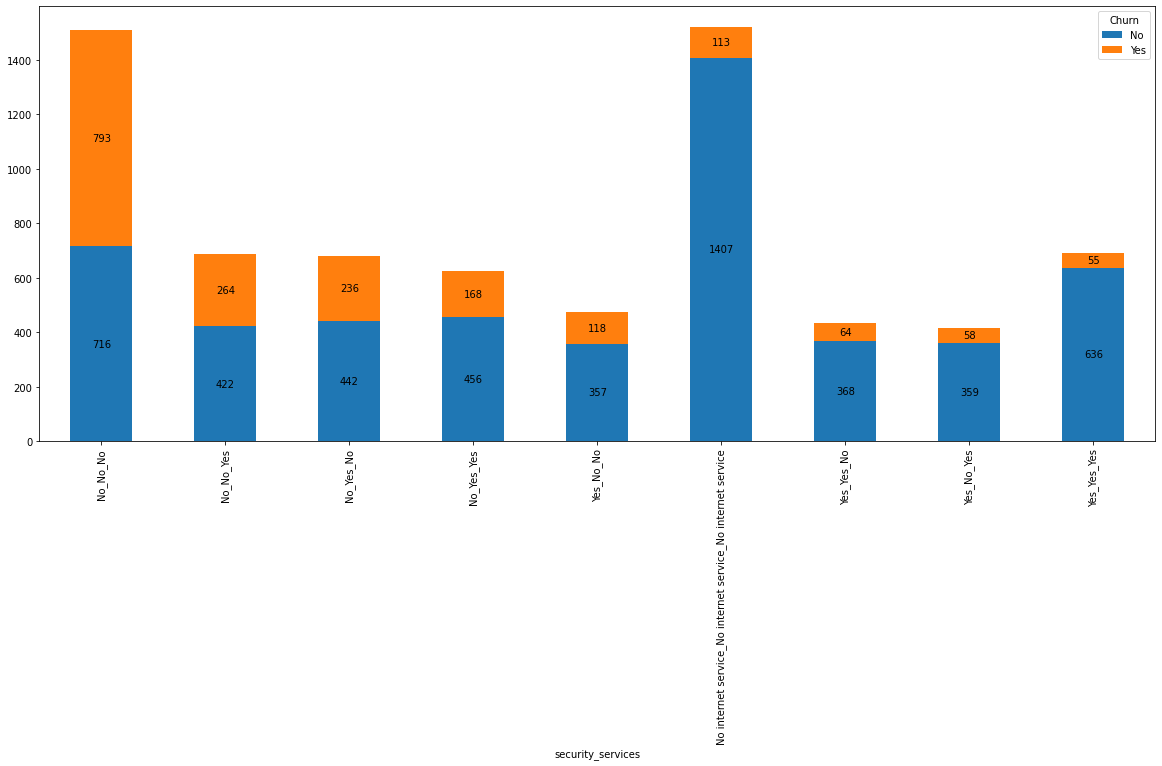

In [60]:
fig, ax = plt.subplots(figsize=(20, 8))
  
ct = pd.crosstab(df["security_services"], df.Churn).sort_values(["Yes"], ascending=False)
# criando gráfico de barras empilhadas
ct.plot(ax=ax, kind="bar", stacked=True, rot=90);

# # adicionando as anotações de cada barra
for c in ax.containers:
  ax.bar_label(c, label_type="center")

# fig.tight_layout()

Temos uma concentração maior de clientes que abandonam a empresa quando nenhum serviço de segurança online ou proteção é assinado.

Vamos isolar clientes que não possuem nenhum serviço de segurança e clientes que possuem pelo menos um serviço de segurança.

In [61]:
df = df.assign(security_services = df.security_services.apply(lambda x: "no" if "Yes" not in x or "No internet service" in x else "yes"))

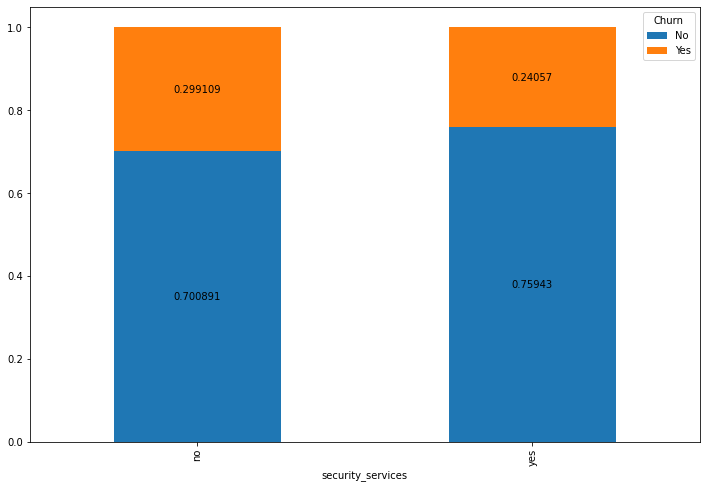

In [62]:
fig, ax = plt.subplots(figsize=(12, 8))
  
ct = pd.crosstab(df["security_services"], df.Churn, normalize="index").sort_values(["Yes"], ascending=False)
# criando gráfico de barras empilhadas
ct.plot(ax=ax, kind="bar", stacked=True, rot=90);

# # adicionando as anotações de cada barra
for c in ax.containers:
  ax.bar_label(c, label_type="center")

# fig.tight_layout()

Clientes que não possuem nenhum tipo de serviço de segurança tem uma taxa 5% maior em relação aos clientes que possuem algum tipo de serviço de segurança.

In [63]:
# atualizando lista de variáveis categóricas
categorical_features = get_categorical_features(df)
categorical_features

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'tenure_description',
 'MonthlyCharges_description',
 'partner_dependents',
 'has_partner_or_dep',
 'streaming_services',
 'security_services']

# Modeling

### Tranformando a variável ``Churn``


In [64]:
# instanciando um objeto LabelEnconder
encoder = LabelEncoder()

# transformando a variável Churn
df["Churn"] = encoder.fit_transform(df.Churn)

# imprimindo as 5 primeiras linhas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_description,MonthlyCharges_description,partner_dependents,has_partner_or_dep,streaming_services,security_services
0,7590-VHVEG,Female,False,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,up to 1 year,up to 30,Yes_No,yes,no,yes
1,5575-GNVDE,Male,False,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,greater than a year to 5 years,31 to 70,No_No,no,no,yes
2,3668-QPYBK,Male,False,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,up to 1 year,31 to 70,No_No,no,no,yes
3,7795-CFOCW,Male,False,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,greater than a year to 5 years,31 to 70,No_No,no,no,yes
4,9237-HQITU,Female,False,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,up to 1 year,71 to 100,No_No,no,no,no


## Baseline

Em Machine Learning, o baseline é uma métrica ou modelo simples que fornece uma linha de base para avaliar a performance de modelos mais complexos. Ele é usado como um ponto de referência para comparar a performance de outros modelos mais avançados e para avaliar se os resultados obtidos pelos modelos são significativos ou não.

In [65]:
# criando uma cópia do DataFrame para ser utilizando no baseline
df_baseline = df.copy()

### Separando dados em treino e teste

In [66]:
# método que faz o split dos dados 
def return_features(df: pd.DataFrame):
  
  # separando os dados entre feature matrix e target vector
  X = df.drop(["customerID", "Churn"], axis=1) 
  y = df.Churn

  # separando os dados para utilizar no treino e teste do modelo
  return train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [67]:
X_train, X_test, Y_train, Y_test = return_features(df_baseline)

# imprimindo o shape dos DataFrames de treino e teste
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(5625, 25) (1407, 25) (5625,) (1407,)


Após o ```LabelEncoder()``` a nova coluna Churn_encode recebeu 0 para Churn = No e 1 para Churn = 1.

In [68]:
df_baseline.Churn.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

### Column transformer e Undersampling

Nesta etapa são criados os objetos ```column_transformer``` que aplica o ```MinMaxScaler()``` nas variáveis numéricas e ```OneHotEncoder()``` nas variáveis categóricas. Todas estas ações de tranformação será delegadas para um "tranformador de colunas" que aqui é chamado de "preprocessor".

Além disso, o objeto ```RandomUnderSampler()``` é instanciado para fazer o balanceamento do nosso ```DataFrame()```.

In [69]:
# seletor de variáveis numéricas
num_col_selector = make_column_selector(dtype_include=np.number)

# seletor de variáveis booleanas (0 e 1)
bin_col_selector = make_column_selector(dtype_include=[bool])

# seletor de variáveis categóricas
cat_col_selector = make_column_selector(dtype_exclude=[bool, np.number])

def identity(x):
    return x

# escalando as colunas
preprocessor = make_column_transformer(
    (MinMaxScaler(), num_col_selector),
    (OneHotEncoder(), cat_col_selector),
    (FunctionTransformer(identity), ['SeniorCitizen']), # aplicando uma função identidade para retornar a coluna SeniorCitizen inalterada
    remainder='passthrough' # todas as colunas que não são transformadas pelo make_column_transformer serão mantidas no conjunto de dados final
)

# objeto para realizar o balancemanto do DataFrame
under_sampling = RandomUnderSampler(sampling_strategy="not minority", random_state=42)

Somente para demonstrar o resultado da execução do re-sampling. Esta etapa será feita no pipeline.

In [70]:
# realizando e resampling
X_train_res, Y_train_res = under_sampling.fit_resample(X_train, Y_train)

print("-"*80)
print("Antes da realização do under-sampling")
print("-"*80)
print(f"A classe majoritária (0 = Cliente não irá abandonar) possui {Y_train[Y_train == 0].shape[0]} registros")
print(f"A classe minoritária (1 = Cliente irá abandonar) possui {Y_train[Y_train == 1].shape[0]} registros")
print("-"*80)
print("Após a realização do under-sampling")
print("-"*80)
print(f"Qtde de registros da classe 0 (Cliente não irá abandonar): {Y_train_res[Y_train_res == 0].shape[0]}")
print(f"Qtde de registros da classe 1 (Cliente irá abandonar): {Y_train_res[Y_train_res == 1].shape[0]}")
print("-"*80)

--------------------------------------------------------------------------------
Antes da realização do under-sampling
--------------------------------------------------------------------------------
A classe majoritária (0 = Cliente não irá abandonar) possui 4130 registros
A classe minoritária (1 = Cliente irá abandonar) possui 1495 registros
--------------------------------------------------------------------------------
Após a realização do under-sampling
--------------------------------------------------------------------------------
Qtde de registros da classe 0 (Cliente não irá abandonar): 1495
Qtde de registros da classe 1 (Cliente irá abandonar): 1495
--------------------------------------------------------------------------------


### Pipeline

Pipeline é uma sequência para pré-processar dados e ajustar um modelo de aprendizado de máquina em uma única etapa. Ele permite que todas as etapas do pré-processamento e ajuste do modelo sejam encapsuladas em uma única estrutura, o que facilita a execução de todo o fluxo de trabalho em um único comando e reduz as chances de erros.

Além disso, o Pipeline pode ser combinado com outras funções do Scikit-Learn, como a validação cruzada, para avaliar a performance do modelo e encontrar os melhores hiperparâmetros para o conjunto de dados em questão.

<img src="https://drive.google.com/uc?export=view&id=1ymz_Gc2OQc6qe0l9qhjp0mx-Lvu44xm3" width="100%"></p>

In [71]:
# dicionario que armazena duas listas:
# 1 - lista das colunas originais do dataset
# 2 - lista das colunas após feature engineering  
columns_dict = {"original": original_col_names, "custom": df_baseline.columns}

report = []

for key, value in columns_dict.items():

  # fazendo o split dos dados usando somente as colunas desejadas (original ou custom)
  X_train, X_test, Y_train, Y_test = return_features(df_baseline[value])

  baseline = make_pipeline( # criando um pipeline
    preprocessor, # normalizando os dados
    under_sampling, # balanceando o DataFrame
    LogisticRegression(solver='lbfgs', max_iter=200)) # usando uma LogisticRegression como modelo

  # treinando o modelo utilizando os dados de treino
  baseline.fit(X_train, Y_train);
  
  # avaliando a acurácia do modelo utilizando os dados de treino
  train_score = baseline.score(X_train, Y_train)
  
  # avaliando acurácia do modelo utilizando os dados de teste
  test_score = baseline.score(X_test, Y_test)

  report.append([key, train_score, test_score])

df_reports = pd.DataFrame(report, columns =["columns set", "train score", "test score"])
df_reports

,columns set,train score,test score
0,original,0.755911,0.727790
1,custom,0.759644,0.727079


Treinando modelos diferentes utilizando somente as colunas originais do dataset e as novas colunas adicionadas no processo de feature engineering não houve uma diferença nos resultados de performance dos modelos.

Nas próximas etapas serão utilizadas outras estratégias afim de melhorar os resultados de performance dos nosso modelos.

In [72]:
# Criando Pipeline para executar os passos:
#
#   1. Pre-processamento das colunas utilizando MinMaxScaler() e OneHotEncode();
#   2. Balanceamento do DataFrame utilizando a técnica de under-sampling;
#   3. Criação de um modelo utilizando uma regressão logística;

baseline = make_pipeline(
    preprocessor,
    under_sampling, 
    LogisticRegression(solver='lbfgs', max_iter=200))

X_train, X_test, Y_train, Y_test = return_features(df_baseline)

# treinando o modelo utilizando os dados de treino
baseline.fit(X_train, Y_train);

# realizando predições usando os dados de teste
Y_pred = baseline.predict(X_test)
Y_pred_proba = baseline.predict_proba(X_test)

# Evaluation

### Matriz de confusão (Baseline)

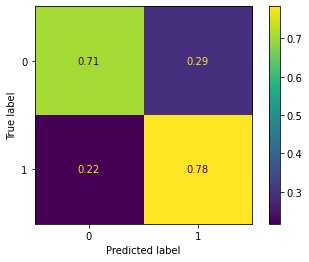

In [73]:
cm = confusion_matrix(y_true=Y_test, y_pred=Y_pred, labels=baseline.classes_, normalize="true")

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseline.classes_)

display.plot();

Na matriz de confusão normalizada podemos avaliar as classificações percentualmente.

Classificações que foram:

* Classificadas como Churn = 0 e realmente são Churn = 0: 71%
* Clientes que não irão abandonar e realmente não abandoram: 71%
---
* Classificadas como Churn = 1 e realmente são Churn = 1: 79%
* Clientes que irão abandonar e realmente abandoram: 79%
---
* Classificadas como Churn = 0 e são Churn = 1: 21%
* Clientes que não irão abandonar e realmente abandoram: 21%
----
* Classificadas como Churn = 1 e são Churn = 0: 29%
* Clientes que irão abandonar e realmente não abandoram: 29%

Na matriz de confusão podemos ver que a taxa de falsos negativos (FN) e falsos positivos (FP) é relativamente alta, entre 20% a 30% respectivamente.

Para o nosso contexto, os FNs possuem um peso maior em relação aos outros.

### Classification report (Baseline)

In [74]:
print(classification_report(y_true=Y_test, y_pred=Y_pred, labels=[0, 1], digits=4))

              precision    recall  f1-score   support

           0     0.9001    0.7067    0.7918      1033
           1     0.4916    0.7834    0.6041       374

    accuracy                         0.7271      1407
   macro avg     0.6959    0.7451    0.6979      1407
weighted avg     0.7915    0.7271    0.7419      1407



In [86]:
_, recall, _, _ = precision_recall_fscore_support(y_true=Y_test, y_pred=Y_pred, average='macro')
print(f"recall médio = {recall}")

recall médio = 0.7450510169745976


Em precision concluimos que:

1. 90% das classificações foram acertivas em Churn = 0
2. 49% das classificações fora acertivas em Churn = 1

Em recall podemos concluir que:

1. Para a classe 0 (não abandono do cliente) obteve-se um recall de 70%, isto significa que nosso modelo classificou corretamente 70% das instâncias rotuladas como Churn = 0;
1. Para a classe 1 (abandono do cliente) obteve-se um recall de 79%, isto significa que nosso modelo classificou corretamente 79% das instâncias rotuladas como Churn = 1.





### ROC curve (Baseline)

In [76]:
# pegando somente as probabilidades da classe 1
lr_fraud_probs = Y_pred_proba[:,1]

# calculando a AUC
lr_auc = roc_auc_score(Y_test, lr_fraud_probs)

print('Regressão logística: AUROC = %.3f' % (lr_auc))

Regressão logística: AUROC = 0.831


In [77]:
# obtendo os valores de FPR e TPR
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_fraud_probs)

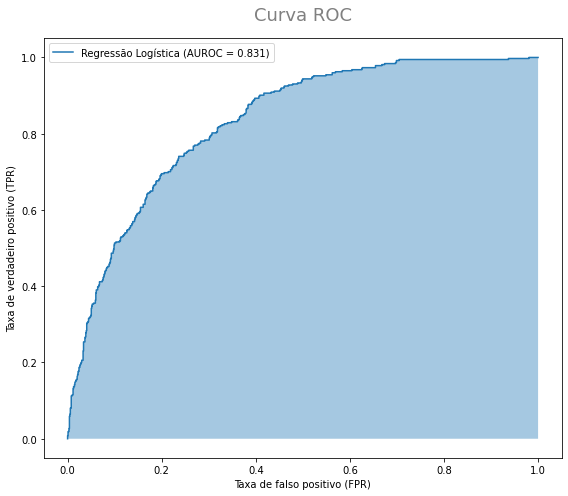

In [78]:
fig, ax = plt.subplots(figsize=(8,7))

ax.plot(lr_fpr, lr_tpr, label='Regressão Logística (AUROC = %0.3f)' % lr_auc)
ax.fill_between(lr_fpr, lr_tpr, alpha=0.4)

ax.set_title('Curva ROC', fontsize=18, pad=18, color="grey")
ax.set_xlabel('Taxa de falso positivo (FPR)')
ax.set_ylabel('Taxa de verdadeiro positivo (TPR)')
ax.legend() 

plt.tight_layout()

plt.savefig("roc_curve.jpeg", dpi=500, bbox_inches='tight')

https://medium.com/data-hackers/como-usar-pipelines-no-scikit-learn-1398a4cc6ae9

## Avaliando com diferentes modelos

Nesta etapa será feita uma busca para saber qual algoritmo consegue performar melhor que o nosso baseline. Alem disso, será usada é uma técnica de validação cruzada chamada K-Fold, utilizada para avaliar a performance de um modelo de Machine Learning.

Os algoritmos que iremos usar são:

1. Logistic Regression
1. Decision Trees
1. Random Forest
1. XGBoost


In [79]:
# criando uma cópia do DataFrame
df_final = df.copy()

# separando em conjuntos X e y. Em X são removidos a coluna
# "customerID" que é irrelevante para o treinamento e "Churn"
#  que é atribuida para o y
X, y = df_final.drop(["customerID", "Churn"], axis=1), df_final.Churn 

In [80]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_description,MonthlyCharges_description,partner_dependents,has_partner_or_dep,streaming_services,security_services
0,Female,False,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,up to 1 year,up to 30,Yes_No,yes,no,yes
1,Male,False,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,greater than a year to 5 years,31 to 70,No_No,no,no,yes
2,Male,False,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,up to 1 year,31 to 70,No_No,no,no,yes
3,Male,False,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,greater than a year to 5 years,31 to 70,No_No,no,no,yes
4,Female,False,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,up to 1 year,71 to 100,No_No,no,no,no


In [81]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

### K-fold

**K-fold** é uma técnica de **validação cruzada** amplamente utilizada em aprendizado de máquina para avaliar a performance de um modelo em dados não vistos.

Em resumo, a técnica divide o conjunto de dados em K partes iguais (ou quase iguais), chamadas de folds. Em seguida, o modelo é treinado K vezes, cada vez usando um fold diferente como conjunto de teste e os K-1 folds restantes como conjunto de treinamento.

Ao final do processo, o desempenho do modelo é avaliado pela média das métricas de desempenho (por exemplo, acurácia, precisão, recall) obtidas em cada uma das K rodadas.

<img src="https://drive.google.com/uc?export=view&id=1XFK436LXbJkp2CTBf5gu5RzVaqwy62vW" width="100%"></p>



### GridSearchCV

Para ajustar os hiperparâmetros de um modelo de machine learning e encontrar melhor combinação de hiperparâmetros para otimizar o desempenho do modelo será utilizado a classe GridSearCV do pacote sklearn.

Neste processo o GridSearchCV utilizada cross-validation (K-fold) para avaliar todas as possíveis combinações de hiperparâmetros.

In [ ]:
# dicionário de hyperparâmetros para o algoritmo LogisticRegression
lr_params = {  
    "logisticregression__solver": ["lbfgs"], # "lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"
    "logisticregression__penalty": ['l2', 'none'], # "l1", "l2", "elasticnet", None]
    "logisticregression__C": [100, 10, 1.0, 0.1, 0.01], # 100, 10, 1.0, 0.1, 0.01
}

# dicionário de hyperparâmetros para o algoritmo DecisionTree
dt_params = {
    "decisiontreeclassifier__criterion": ['gini', 'entropy'],
    "decisiontreeclassifier__splitter": ['best', 'random'], 
    "decisiontreeclassifier__min_samples_split": [4, 8, 16],
    "decisiontreeclassifier__min_samples_leaf": [1, 2, 4, 8],
    "decisiontreeclassifier__max_depth": [None, 4, 8],
    "decisiontreeclassifier__class_weight": [None, 'balanced']    
}

# dicionário de hyperparâmetros para o algoritmo RandomForest
rf_params = {
    "randomforestclassifier__criterion": ['gini', 'entropy'],
    "randomforestclassifier__min_samples_split": [16, 20, 24, 28, 32],
    "randomforestclassifier__max_depth": [None, 4, 8], 
    "randomforestclassifier__class_weight": [None, 'balanced'], 
    "randomforestclassifier__max_features": [None, 'sqrt', 'log2'], 
}

# dicionário de hyperparâmetros para o algoritmo XGBoostClassifier
gb_params = {
    "xgbclassifier__learning_rate": [0.001, 0.01, 0.1],
    "xgbclassifier__n_estimators": [10, 100, 1000],
    "xgbclassifier__subsample": [0.5, 0.7, 1.0],
    "xgbclassifier__max_depth": [None, 4, 8]
}

# utilizando KFold com embralhamento dos dados para separar os dados
# em 5 partes, onde, 4 serão utilizados para o treinamento e 1 será
# utilizada para teste. 
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# colocando os dicionários de hyperparâmetro em uma list
alg_param_grids = [lr_params, dt_params, rf_params, gb_params]

# colocando os labels dos algoritmos em uma lista
alg_labels = ["LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", "XGBClassifier"]

# lista vazia para armazenar os resultados
report = []

# laço for para testas diferentes quantidade de features do DataFrame
for k in range(5, X.shape[1]+2, 2):

  # selecionando somente as k featutes mais importantes
  selectKBest = SelectKBest(score_func=f_classif, k=k)

  # criando pipeline para cada algoritmo
  lr_pipeline = make_pipeline(preprocessor, selectKBest, under_sampling, LogisticRegression(max_iter=500))
  dt_pipeline = make_pipeline(preprocessor, selectKBest, under_sampling, DecisionTreeClassifier())
  rf_pipeline = make_pipeline(preprocessor, selectKBest, under_sampling, RandomForestClassifier())
  gb_pipeline = make_pipeline(preprocessor, selectKBest, under_sampling, XGBClassifier())

  # colocando os pipeline em uma lista
  alg_pipelines = [lr_pipeline, dt_pipeline, rf_pipeline, gb_pipeline]

  # laço for para fazer oa GridSearch de cada algoritmos com seus respectivos hyperparâmetros
  for model, param_grid, alg in zip(alg_pipelines, alg_param_grids, alg_labels):

    print("-"*50)
    print(f"{alg} - SelectKBest={k}")
    print("-"*50)

    # criando GridSearch
    grid_search_model = GridSearchCV(estimator=model, param_grid=param_grid, return_train_score=True, cv=cv, scoring="recall", n_jobs=-1, verbose=1)

    # treinando o modelo
    grid_search_model.fit(X, y)

    print(f"Melhores parâmetros: {grid_search_model.best_params_}")
    print(f"recall: {grid_search_model.best_score_:.4f}") # Mean cross-validated score of the best_estimator"

    # armazenando resultados em lista
    report.append([alg, k, grid_search_model.best_score_])

df_reports = pd.DataFrame(report, columns =["model", "k_features", "recall"]).sort_values(["recall"], ascending=False)
df_reports

--------------------------------------------------
LogisticRegression - SelectKBest=5
--------------------------------------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores parâmetros: {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
recall: 0.7693
--------------------------------------------------
DecisionTreeClassifier - SelectKBest=5
--------------------------------------------------
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Melhores parâmetros: {'decisiontreeclassifier__class_weight': None, 'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__min_samples_leaf': 4, 'decisiontreeclassifier__min_samples_split': 4, 'decisiontreeclassifier__splitter': 'best'}
recall: 0.8131
--------------------------------------------------
RandomForestClassifier - SelectKBest=5
--------------------------------------------------
Fittin

,model,k_features,recall
2,RandomForestClassifier,5,0.826463
3,XGBClassifier,5,0.823668
6,RandomForestClassifier,7,0.822253
26,RandomForestClassifier,17,0.821450
30,RandomForestClassifier,19,0.820914
34,RandomForestClassifier,21,0.818619
18,RandomForestClassifier,13,0.817482
10,RandomForestClassifier,9,0.817433
38,RandomForestClassifier,23,0.817401
42,RandomForestClassifier,25,0.816782


De acordo com os vários testes feitos que GridSearchCV nossos modelos TOP3 vencedores foram:

1. **RandomForestClassifier**	com recall de **0.826463** utilizando apenas **5** features do DataFrame
2. **XGBClassifier** com recall de **0.823668** utilizando apenas **5** features do DataFrame
3. **RandomForestClassifier**	com recall de **0.822253** utilizando **7** features do Dataframe

Com os seguinte hyperparâmetros:

1. **RandomForestClassifier**
    * class_weight: 'balanced,
    * criterion: entropy,
    * max_depth: 4,
    * max_features: None,
    * min_samples_split: 28
2. **XGBClassifier**
    * learning_rate: 0.001, 
    * max_depth: 4,
    * n_estimators: 100,
    * subsample: 0.7
3. **RandomForestClassifier**
    * class_weight: balanced,
    * criterion: gini,
    * max_depth: 4,
    * max_features: sqrt,
    * min_samples_split: 28

Encontrado o algoritmo vencedor e seus hyperparâmetros podemos usar o conjunto completo de dados de treinamento para construir o novo modelo com estes hyperparâmetros.


### Utilizando StackingClassifier

Nesta etapa é feita uma combinação da saída de vários modelos de classificação em um meta-modelo que pode produzir resultados mais precisos do que qualquer modelo individual.

Dessa forma o processo de Stacking treina todos os modelos que foram "empilhados" e usa suas previsões como entrada para um modelo de meta-aprendizagem. 

O modelo de meta-aprendizagem combina as previsões individuais de cada modelo e faz uma única previsão final. O objetivo é criar um modelo de meta-aprendizagem que combine as forças dos modelos de base e minimize suas fraquezas.

In [ ]:
lr_pipeline = make_pipeline(preprocessor, under_sampling, LogisticRegression(max_iter=200, n_jobs=-1))
dt_pipeline = make_pipeline(preprocessor, under_sampling, DecisionTreeClassifier())
rf_pipeline = make_pipeline(preprocessor, under_sampling, RandomForestClassifier(n_estimators=50, n_jobs=-1))
gb_pipeline = make_pipeline(preprocessor, under_sampling, XGBClassifier(n_jobs=-1))

estimators = [
    ("lr", lr_pipeline),
    ("dt", dt_pipeline),
    ("rf", rf_pipeline),
    ("gb", gb_pipeline)
]

classifiers = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())


params = {
    'final_estimator__n_estimators': [10, 100, 1000],
    'rf__randomforestclassifier__max_depth': [5, 10, 15],
    'rf__randomforestclassifier__min_samples_split': [2, 5, 10],
    'lr__logisticregression__C': [0.1, 1, 10]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = GridSearchCV(estimator=classifiers, param_grid=params, return_train_score=True, cv=cv, scoring='recall', n_jobs=-1, verbose=5)

models.fit(X, y)

print(f"Melhores parâmetros: {models.best_params_}")
print(f"AUC: {models.best_score_:.4f}") # Mean cross-validated score of the best_estimator"

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores parâmetros: {'final_estimator__n_estimators': 1000, 'lr__logisticregression__C': 0.1, 'rf__randomforestclassifier__max_depth': 5, 'rf__randomforestclassifier__min_samples_split': 2}
AUC: 0.5179


Na construção do Pipeline utilizando ```make_pipeline``` e ```StackingClassifier``` obtive o erro abaixo:

```
ValueError: Invalid parameter C for estimator Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1dec598c10>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1dec598f40>),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<function identity at 0x7f1dec58fc10>),
                                                  ['SeniorCitizen'])])),
                ('randomundersampler',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='not minority')),
                ('logisticregression', LogisticRegression())]). Check the list of available parameters with `estimator.get_params().keys()`.
```

Minha lista de parâmetro as ser passado para o ```param_grid``` do GridSearch originalmente estava assim:

```
params = {
    'final_estimator__n_estimators': [10, 100, 1000],
    'rf__max_depth': [5, 10, 15],
    'rf__min_samples_split': [2, 5, 10],
    'lr__C': [0.1, 1, 10],
}
```

Após muita pesquisa sem sucesso, fiz a [pergunta no stackoverflow](https://stackoverflow.com/questions/75565967/invalid-parameter-for-estimator-pipeline) e recebi e resposta abaixo do usuário [user1808924](https://stackoverflow.com/users/1808924/user1808924).



```
The make_pipeline function creates an intermediate Pipeline level, which is not handled in your fit param addressing syntax.

Right now you have: lr__C. But you should be having lr__logisticregression__C.
```

Fiz a correção na minha lista de parâmetros e bingo, funcionou!

```
params = {
    'final_estimator__n_estimators': [10, 100, 1000],
    'rf__randomforestclassifier__max_depth': [5, 10, 15],
    'rf__randomforestclassifier__min_samples_split': [2, 5, 10],
    'lr__logisticregression__C': [0.1, 1, 10]
}
```






In [ ]:
from sklearn import set_config
from sklearn.utils import estimator_html_repr
import IPython

# set config to diagram for visualizing the pipelines/composite estimators
set_config(display='diagram')

# saving pipeline as html format
with open('churn_data_pipeline_estimator.html', 'w') as f:  
    f.write(estimator_html_repr(models.best_estimator_))

In [ ]:
IPython.display.HTML(filename='/content/churn_data_pipeline_estimator.html')

Na imagem acima é possível ver com mais clareza como o StackingClassifier é estruturado internamente. Além disso podemos visualmente todas as etapas do pipeline até o momento do treinamento do algoritmo.

# Conclusões

Neste projeto foi possível aplicar varia técnias utilizadas na construção de modelos de machine learning. A etapa de feature engineering embora não tenha trazido uma melhora na performance da baseline constuida fui util para entendermos melhor os dados disponibilizados e extrair outros insights.

Entender os tipos de variáveis contidas nos dados também nos ajudaram a definir melhor quais as tranformações/normalizações são mais adequadas para cada tipo de variável.

Os métodos make_column_selector e column_transformer do sklearn se mostraram essenciais para simplificar e evitar erros no processo de seleção e tranformação dos nossos dados antes de iniciar o treinamento dos modelos

Outro método que automatizou e trouzxe agilidade na etapa de fine-tunning (ajuste fino dos hyperparâmetros de um modelo de aprendizado de máquina) foi o GridSearchCV onde foi possivel entregar para este método uma lista de pipelines contendo diferentes algoritmos de machine learning juntamente com uma grade (grid) com diferentes hyperparâmetros. Com isso, o GridSearchCV realizou todos os testes necessários e pode nos retornar o melhor algoritmo e os hyperparâmetros que tiveram o melhor desempenho nas predições.

Junto com o GridSearchCV foi utilizado também o K-fold para fazer a divisão dos nossos dados de treino e teste, assim, foi possivel testar nosso modelo embaralhando os nossos dados de divesos jeitos diferentes.

Combinando todas estas técnicas foi possível aumentar o recall de 0.74505 obtido pela nossa baseline para 0.826463.



# References

1. [What is Feature Engineering for Machine Learning?](https://medium.com/mindorks/what-is-feature-engineering-for-machine-learning-d8ba3158d97a)
1. [Fundamental Techniques of Feature Engineering for Machine Learning](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114)
1. [Discover Feature Engineering, How to Engineer Features and How to Get Good at It](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)
1. [Tune Hyperparameters for Classification Machine Learning Algorithms](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/)
1. [About Feature Scaling and Normalization (Sebastian Raschka)](https://sebastianraschka.com/Articles/2014_about_feature_scaling.html)
1. [Feature Scaling for Machine Learning: Understanding the Difference Between Normalization vs. Standardization](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/)
1. [Normalization vs Standardization — Quantitative analysis](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)
1. [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)
1. [Evaluating Machine Learning Models](https://medium.com/datadriveninvestor/evaluating-machine-learning-models-8e2193c2b237)
1. [Validation Sets and Test Sets: Programming Exercise (Google Machine Learning Crash Course)](https://developers.google.com/machine-learning/crash-course/validation/programming-exercise)
1. [Cross Validation — Why & How](https://towardsdatascience.com/cross-validation-430d9a5fee22)
1. [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection)
1. [Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
1. [Pipelines and composite estimators](https://scikit-learn.org/stable/modules/compose.html#combining-estimators)
1. [Logistic Regression Model Tuning with scikit-learn](https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5)
1. [Tune Hyperparameters for Classification Machine Learning Algorithms](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/)
1. [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)
1. [Parameter estimation using grid search with cross-validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py)
1. [Model selection: choosing estimators and their parameters](https://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html)



